In [15]:
import numpy as np
import matplotlib.pyplot as plt
from common.util import *
from common.functions import *


## 勾配爆発、勾配消失

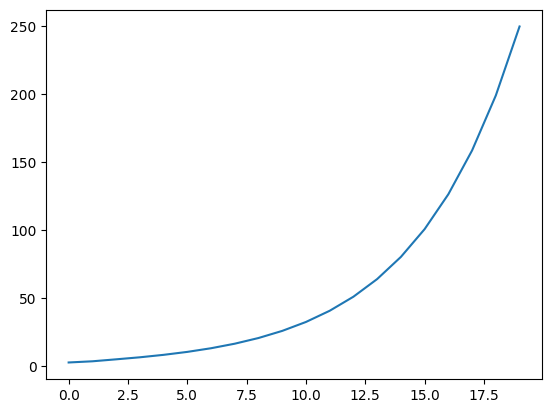

In [9]:
# 勾配爆発

N = 2
H = 3
T = 20

dh = np.ones((N, H))
np.random.seed(3)
Wh = np.random.randn(H, H)

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

plt.plot(np.arange(len(norm_list)), norm_list)

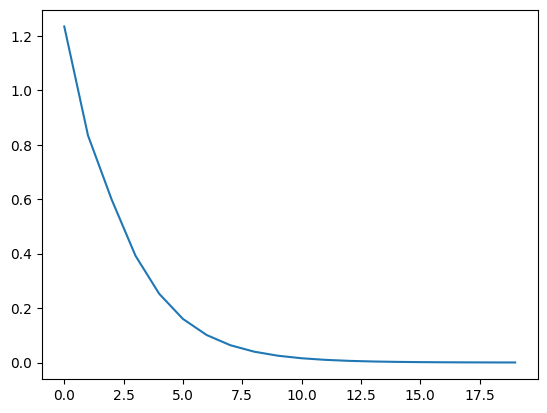

In [10]:
# 勾配消失
# Whに0.５をかける

N = 2
H = 3
T = 20

dh = np.ones((N, H))
np.random.seed(3)
Wh = np.random.randn(H, H) * 0.5

norm_list = []
for t in range(T):
    dh = np.dot(dh, Wh.T)
    norm = np.sqrt(np.sum(dh**2)) / N
    norm_list.append(norm)

plt.plot(np.arange(len(norm_list)), norm_list)

In [12]:
# 勾配クリッピング
dw1 = np.random.rand(3, 3) * 10
dw2 = np.random.rand(3, 3) * 10
grads = [dw1, dw2]
max_norm = 5.0

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad**2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / total_norm
    if rate < 1:
        for grad in grads:
            grad *= rate # ndarrayのミュータブルを利用して、gradsの値を更新


clip_grads(grads, max_norm)

# LSTMの実装

In [1]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b] # Wx, Whは4つ分のparameterが格納 -> 各要素数は　H
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh),np.zeros_like(b)]
        self.chache = None


    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape

        # Affine
        A = np.dot(h_prev * Wh) + np.dot(x * Wx) + b
        f = A[:, :H]
        g = A[:, H:H*2]
        i = A[:, H*2:H*3]
        o = A[:, H*3:]

        # activation
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)


        # outputの計算
        c_next = c_prev * f + g * i
        h_next = np.tanh(c_next) * o


        self.chache = [x, h_prev, c_prev, f, g, i, o, c_next]
        
        return c_next, h_next 


    def backward(self, dhs): # backwardはtrancated BPTTなのでh, cは使わないのでは？
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for idx, grad in layer.grads:
                grads[idx] += grad

        for i, grad in grads:
            self.grads[i][...] = grad

        self.dh = dh # seq2seqに使用
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

In [14]:
from common.time_layers import *
import pickle

class Rnnlm:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 重みの初期値
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)            
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1] # reset_state用

        # 全ての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

        
    # forward用にpredictを実装
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)

        return dout


    def reset_state(self):
        self.lstm_layer.reset_state()

    def save_prams(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)


    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f)
            

| epoch 1 |  iter 1 / 1327 | time 2[s] | perplexity 9999.95
| epoch 1 |  iter 21 / 1327 | time 7[s] | perplexity 2862.23
| epoch 1 |  iter 41 / 1327 | time 11[s] | perplexity 1251.21
| epoch 1 |  iter 61 / 1327 | time 15[s] | perplexity 977.16
| epoch 1 |  iter 81 / 1327 | time 19[s] | perplexity 814.75
| epoch 1 |  iter 101 / 1327 | time 24[s] | perplexity 670.86
| epoch 1 |  iter 121 / 1327 | time 28[s] | perplexity 645.39
| epoch 1 |  iter 141 / 1327 | time 32[s] | perplexity 596.12
| epoch 1 |  iter 161 / 1327 | time 36[s] | perplexity 569.58
| epoch 1 |  iter 181 / 1327 | time 40[s] | perplexity 564.58
| epoch 1 |  iter 201 / 1327 | time 44[s] | perplexity 498.41
| epoch 1 |  iter 221 / 1327 | time 48[s] | perplexity 483.04
| epoch 1 |  iter 241 / 1327 | time 51[s] | perplexity 435.45
| epoch 1 |  iter 261 / 1327 | time 56[s] | perplexity 463.20
| epoch 1 |  iter 281 / 1327 | time 60[s] | perplexity 448.52
| epoch 1 |  iter 301 / 1327 | time 65[s] | perplexity 392.37
| epoch 1 |  

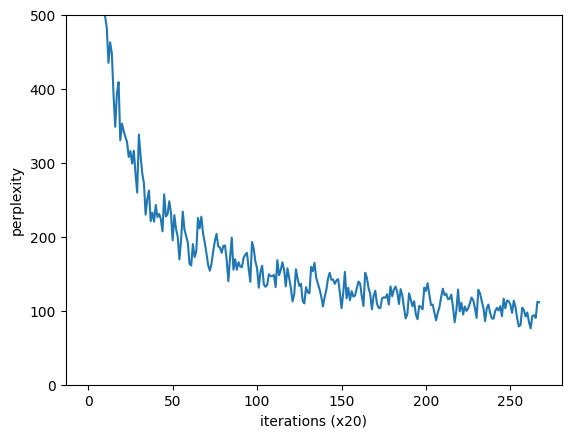

evaluating perplexity ...
234 / 235
test_perplocity: 136.14257386026725


In [15]:
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from hidden_others.dataset import ptb


# ハイパーパラメータ
batch_size = 20
wordvec_size = 100
hidden_size = 100
time_size = 35
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# モデルの生成
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 勾配クリッピングの適応
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

# テストデータの評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test_perplocity:', ppl_test)

# パラメータの保存
model.save_prams()

